In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
from shapely.geometry import Point
from pyproj import Proj, transform
import geopandas as gpd
import matplotlib.pyplot as plt

P3857 = Proj(init='epsg:3857') # mercader special, meters
P4326 = Proj(init='epsg:4326') # lat/lon

In [3]:
# Pull in the latitude and longitude from gtfs data 
gtfs_data_path = "data/mmt_gtfs/"
lat_lon_file = 'stops.csv'
lat_lon_df = pd.read_csv(gtfs_data_path + lat_lon_file)
#lat_lon_df.head(3)

In [4]:
# Convert to shapely point objects in tuples
ID_points = [Point(lat_lon_df['stop_lon'][i], lat_lon_df['stop_lat'][i]) for i in range(len(lat_lon_df))]
#ID_points[0].coords[:]

In [5]:
farthest_points = [ID_points[0] for i in range(4)]

for point in ID_points:
    if point.y > farthest_points[0].y: # north = largest y (lat)
        farthest_points[0] = point
    if point.x > farthest_points[1].x: # east = largest x (lon)
        farthest_points[1] = point
    if point.y < farthest_points[2].y: # south = smallest y (lat)
        farthest_points[2] = point
    if point.x < farthest_points[3].x: # west = smallest x (lon)
        farthest_points[3] = point

farthest_points_mercader = [0, 0, 0, 0]
for i, point in enumerate(farthest_points):
    x, y = transform(P4326, P3857, point.x, point.y)
    farthest_points_mercader[i] = (x, y)
            
#farthest_points_mercader

max_sep:  17757.96347006876


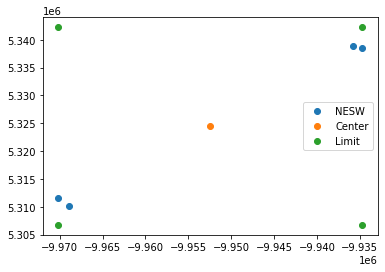

In [7]:
# Find the center of the system: 
center_lon = (farthest_points_mercader[3][0] + 
              abs(farthest_points_mercader[1][0] - farthest_points_mercader[3][0])/2)
center_lat = (farthest_points_mercader[2][1] + 
              abs(farthest_points_mercader[0][1] - farthest_points_mercader[2][1])/2)

max_sep = max(abs(farthest_points_mercader[1][0] - farthest_points_mercader[3][0])/2, 
              abs(farthest_points_mercader[0][1] - farthest_points_mercader[2][1])/2)

print("max_sep: ", max_sep)

xs = [farthest_points_mercader[i][0] for i in range(len(farthest_points_mercader))]
ys = [farthest_points_mercader[i][1] for i in range(len(farthest_points_mercader))]

plt.scatter(xs, ys, label='NESW')
plt.scatter(center_lon, center_lat, label='Center')
plt.scatter([center_lon+max_sep, center_lon-max_sep, center_lon-max_sep, center_lon+max_sep],
            [center_lat+max_sep, center_lat+max_sep, center_lat-max_sep, center_lat-max_sep], label='Limit')
plt.legend()
plt.show()

In [8]:
center_lon = round(center_lon, 2)
center_lat = round(center_lat, 2)
max_sep = round(max_sep, 2)
max_sep + 2000

19757.96

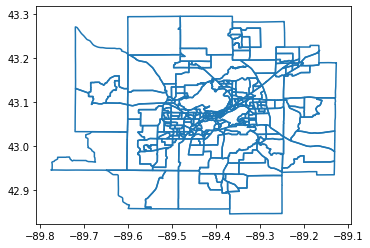

In [9]:
base_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/11/query?"
geometry = "geometry=" + str(round(center_lon, 2)) + "%2C" + str(round(center_lat, 2)) + "&"
mid_url = "geometryType=esriGeometryPoint&spatialRel=esriSpatialRelIntersects&"
distance = "distance=" + str(round(max_sep, 2) + 2000) + "&units=esriSRUnit_Meter&"
end_url = "outFields=STATE%2CCOUNTY%2CTRACT%2CBLKGRP&returnGeometry=true&returnTrueCurves=false&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&featureEncoding=esriDefault&f=geojson"

url = base_url + geometry + mid_url + distance + end_url

df = gpd.read_file(url)
df.boundary.plot()
plt.show()

In [10]:
def plotArea_LatLon(lon, lat, dist_meters):
    x, y = transform(P4326, P3857, lon, lat)
    base_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/11/query?"
    geometry = "geometry=" + str(round(x, 2)) + "%2C" + str(round(y, 2)) + "&"
    mid_url = "geometryType=esriGeometryPoint&spatialRel=esriSpatialRelIntersects&"
    distance = "distance=" + str(round(dist_meters, 2) + 2000) + "&units=esriSRUnit_Meter&"
    end_url = "outFields=STATE%2CCOUNTY%2CTRACT%2CBLKGRP&returnGeometry=true&returnTrueCurves=false&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&featureEncoding=esriDefault&f=geojson"

    url = base_url + geometry + mid_url + distance + end_url

    df = gpd.read_file(url)
    print(df.head())
    df.boundary.plot()
    plt.show()

  STATE COUNTY   TRACT BLKGRP  \
0    27    077  460400      1   

                                            geometry  
0  POLYGON ((-95.32715 48.97978, -95.32716 48.979...  


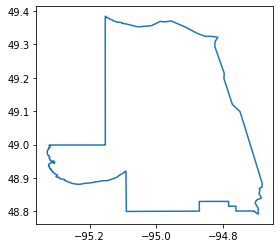

In [11]:
plotArea_LatLon(-95.058198, 49.279038, dist_meters=10000)